In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Carregar o conjunto de dados

In [2]:
df = pd.read_csv("../data/Student_Depression_Cleaned.csv", sep=',')

### 2. Definição das features e o target

In [3]:
features = [
    'Academic Pressure', 'Have you ever had suicidal thoughts ?','Weighted Stress','Academic_Work_Interaction',
    'Financial Stress','Risk Group','Academic_Financial_Interaction','Work_Financial_Interaction',
]

X = df[features]
y = df['Depression']

### 3. Dividisão dos dados em conjuntos de treino e teste

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2698)

print("Tamanho treino: " + str(len(X_train)))
print("Tamanho teste: " + str(len(X_test)))

Tamanho treino: 19483
Tamanho teste: 8350


### 4. Construir uma árvore de decisão com a instância de treino

In [5]:
tree_initial = DecisionTreeClassifier(random_state=42)
tree_initial.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 5. Computar Ein e Eout para analisar overfitting

In [6]:
y_train_pred_initial = tree_initial.predict(X_train)
y_test_pred_initial = tree_initial.predict(X_test)

ein = 1 - accuracy_score(y_train, y_train_pred_initial)
eout = 1 - accuracy_score(y_test, y_test_pred_initial)

print(f"Erro dentro da amostra (Ein): {ein:.4f}")
print(f"Erro fora da amostra (Eout): {eout:.4f}")

if ein < eout and (eout - ein) > 0.1:
    print("Possível Overfitting")
else:
    print("Árvore Equilibrada")

Erro dentro da amostra (Ein): 0.1601
Erro fora da amostra (Eout): 0.1834
Árvore Equilibrada


### 3. Plotar Árvore Inicial

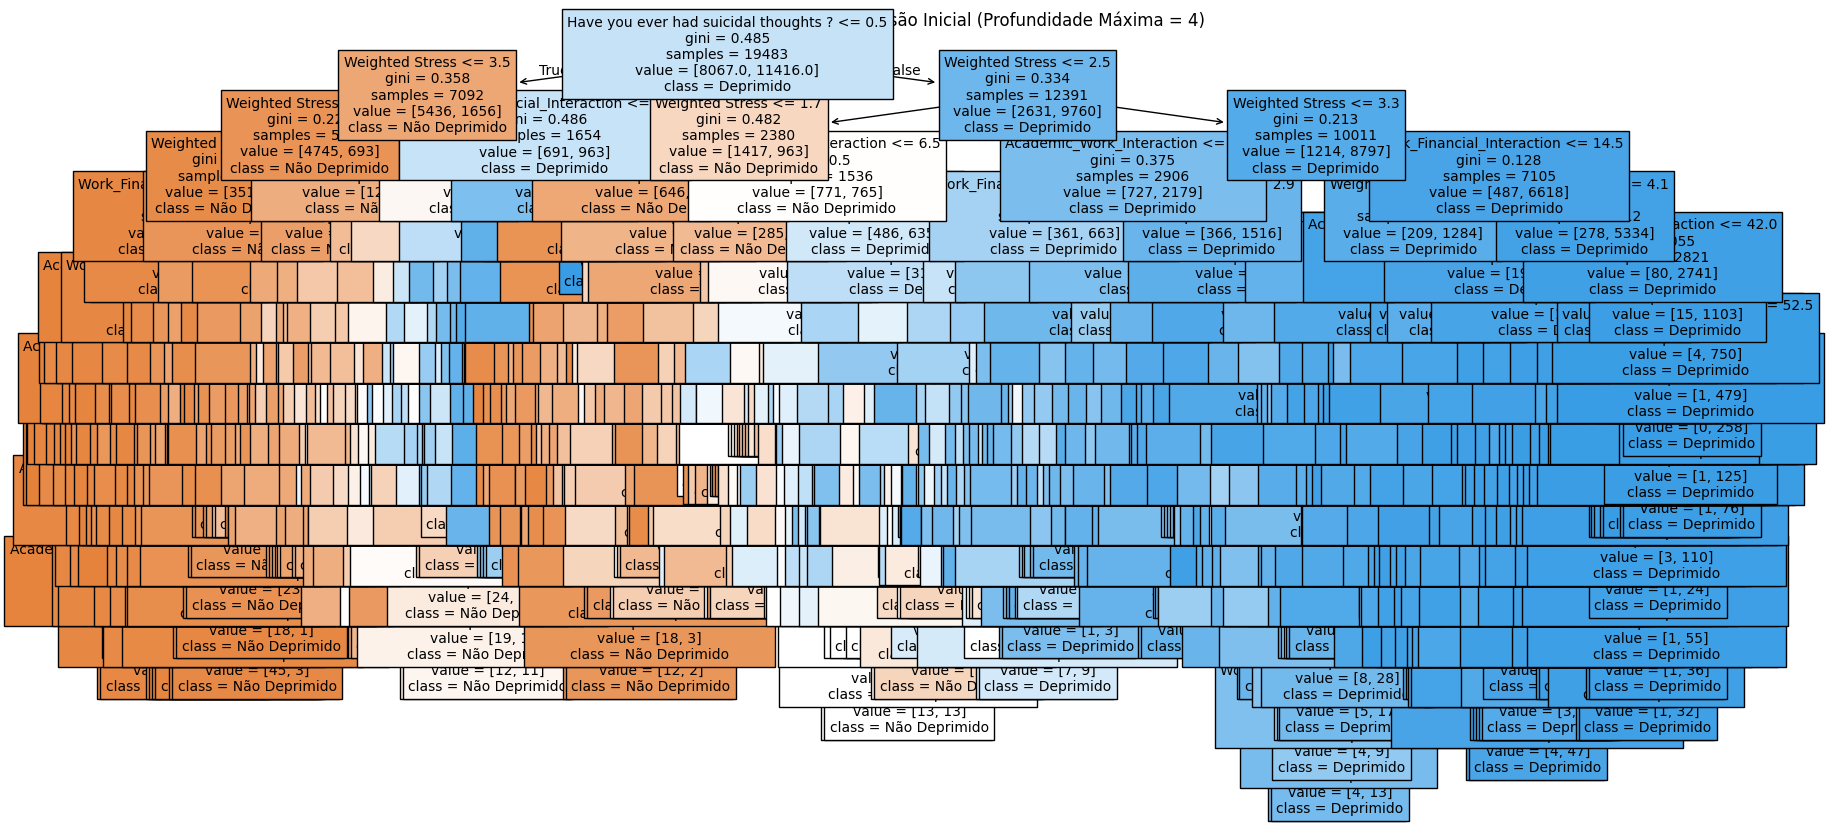

In [7]:
plt.figure(figsize=(20, 10))
plot_tree(tree_initial,
          filled=True,
          feature_names=features,
          class_names=['Não Deprimido', 'Deprimido'],
          fontsize=10)
plt.title("Visualização da Árvore de Decisão Inicial (Profundidade Máxima = 4)")
plt.show()


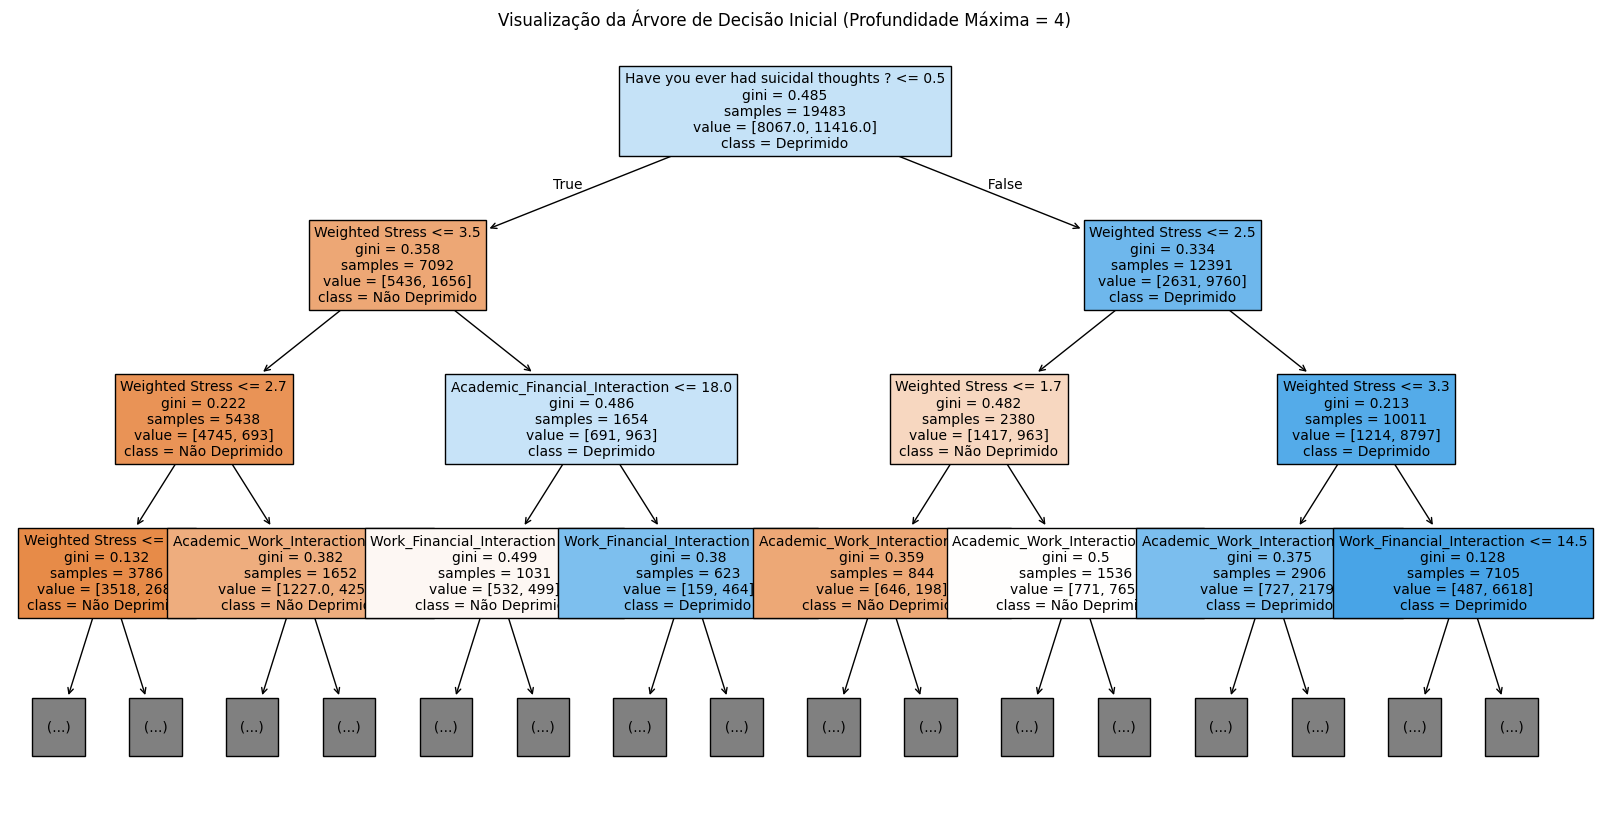

In [8]:
plt.figure(figsize=(20, 10))
plot_tree(tree_initial,
          filled=True,
          feature_names=features,
          class_names=['Não Deprimido', 'Deprimido'],
          max_depth=3,
          fontsize=10)
plt.title("Visualização da Árvore de Decisão Inicial (Profundidade Máxima = 4)")
plt.show()

### 4. Regularização com Minimal Cost-Complexity Pruning

In [9]:
path = tree_initial.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

print(f"Encontrados {len(ccp_alphas)} valores de alpha para a poda.")

Encontrados 713 valores de alpha para a poda.


### 5. Usar GridSearchCV para encontrar o melhor alpha com validação cruzada

In [10]:
ccp_alphas = ccp_alphas[ccp_alphas >= 0]

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid={'ccp_alpha': ccp_alphas},
    cv=10,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ccp_alpha']

print(f"Melhor valor de alpha (α) encontrado: {best_alpha:.6f}")

Melhor valor de alpha (α) encontrado: 0.000437


### 6. Avaliação da Melhor Árvore

In [11]:
y_train_pred_best = best_tree.predict(X_train)
y_test_pred_best = best_tree.predict(X_test)

ein_best = 1 - accuracy_score(y_train, y_train_pred_best)
eout_best = 1 - accuracy_score(y_test, y_test_pred_best)

print(f"Erro dentro da amostra (Ein): {ein_best:.4f}")
print(f"Erro fora da amostra (Eout): {eout_best:.4f}")

Erro dentro da amostra (Ein): 0.1693
Erro fora da amostra (Eout): 0.1732


### 7. Relatório de classificação

In [12]:
print(classification_report(y_test, y_test_pred_best))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      3469
           1       0.83      0.88      0.86      4881

    accuracy                           0.83      8350
   macro avg       0.82      0.82      0.82      8350
weighted avg       0.83      0.83      0.83      8350



### 8. Matriz de Confusão

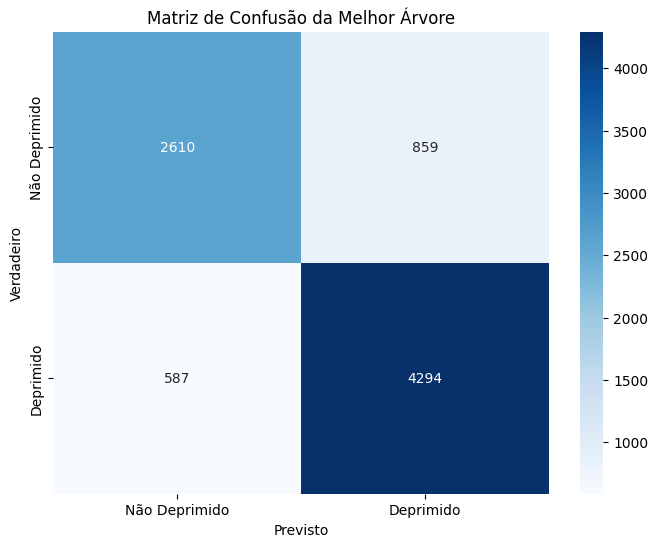

In [13]:
cm = confusion_matrix(y_test, y_test_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Deprimido', 'Deprimido'], yticklabels=['Não Deprimido', 'Deprimido'])
plt.title('Matriz de Confusão da Melhor Árvore')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

### 9. Melhor Árvore

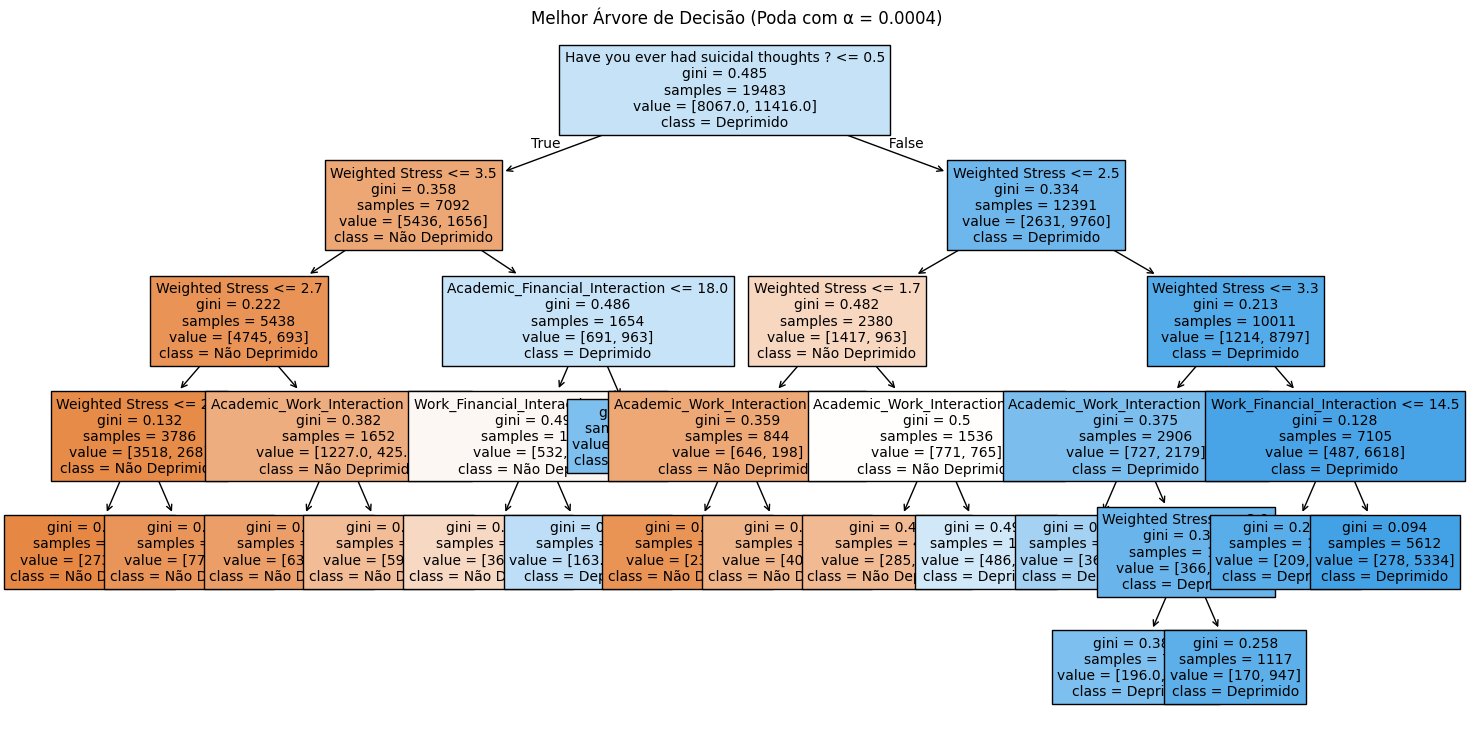

A árvore final tem 16 folhas e profundidade 5.


In [14]:
plt.figure(figsize=(18, 9))
plot_tree(best_tree,
          filled=True,
          feature_names=features,
          class_names=['Não Deprimido', 'Deprimido'],
          fontsize=10)
plt.title(f"Melhor Árvore de Decisão (Poda com α = {best_alpha:.4f})")
plt.show()

print(f"A árvore final tem {best_tree.get_n_leaves()} folhas e profundidade {best_tree.get_depth()}.")